# Assignment3 - Question 1  (Alejandro Akifarry - 301-195-788)
---

## Imports

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

---

## 1. Retrieve and load the Olivetti faces dataset

In [2]:
olivetti_faces = fetch_olivetti_faces()
X = olivetti_faces.data
y = olivetti_faces.target
images = olivetti_faces.images # 64x64 version of .data
print(X.shape)
print(y.shape)

(400, 4096)
(400,)


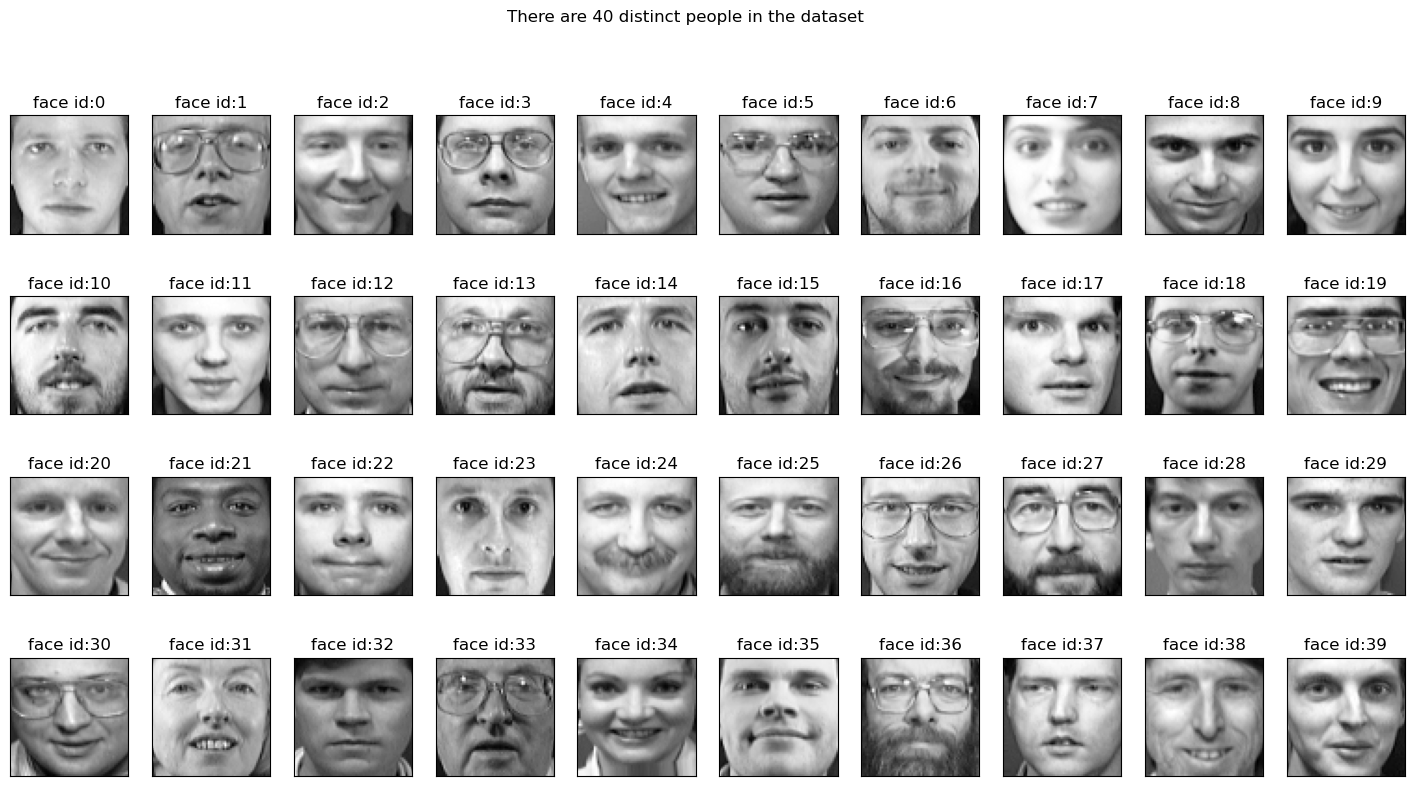

In [4]:
# From Reference [1]
def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")

show_40_distinct_people(images, np.unique(y))

---

## 2. Split the training set, a validation set, and a test set using stratified sampling to ensure that there are the same number of images per person in each set.

In [5]:
'''
Split is:
80% train
10% validation
10% test
to ensure we have a lot of data to train, 
and also still have some left for validation and testing
'''
# First split into train + validation (90%) and test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# Now split the train + validation set (90%) into train (80%) and validation (10%)
# 10/90 = 0.1111
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1111, random_state=42, stratify=y_train_val)

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(320, 4096)
(40, 4096)
(40, 4096)


---

## 3. Using k-fold cross validation, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.

In [7]:
# Use SVC with linear kernel
clf = SVC(kernel='linear', random_state=42)

# Instantiate StratifiedKFold
# use n_splits=4 so the 8 training samples per class can be evenly distributed
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Run k-fold CV
cv_scores = cross_val_score(clf, X_train, y_train, cv=kf, scoring='accuracy')

# Print scores
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

# Train the classifier on the entire training set
clf.fit(X_train, y_train)

# Evaluate the classifier on the validation set
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation set accuracy: {val_accuracy:.4f}")

Cross-validation accuracy scores: [0.95   0.9875 0.9875 0.9375]
Mean cross-validation accuracy: 0.9656
Validation set accuracy: 0.9750


---

## 4. Using either Agglomerative Hierarchical Clustering (AHC) or Divisive Hierarchical Clustering (DHC) and using the centroid-based clustering rule, reduce the dimensionality of the set by using the following similarity measures:

In [125]:
n_clusters = 40

In [126]:
# From Reference [2]
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### a) Euclidean Distance

In [131]:
# Use euclidean distance
dist_euclidean = pdist(X, metric="euclidean")

# Perform agglomerative clustering
Z_euclidean = linkage(dist_euclidean, method="centroid")

# Get labels (which cluster each point belongs to)
labels_euclidean = fcluster(Z, t=n_clusters, criterion="maxclust")

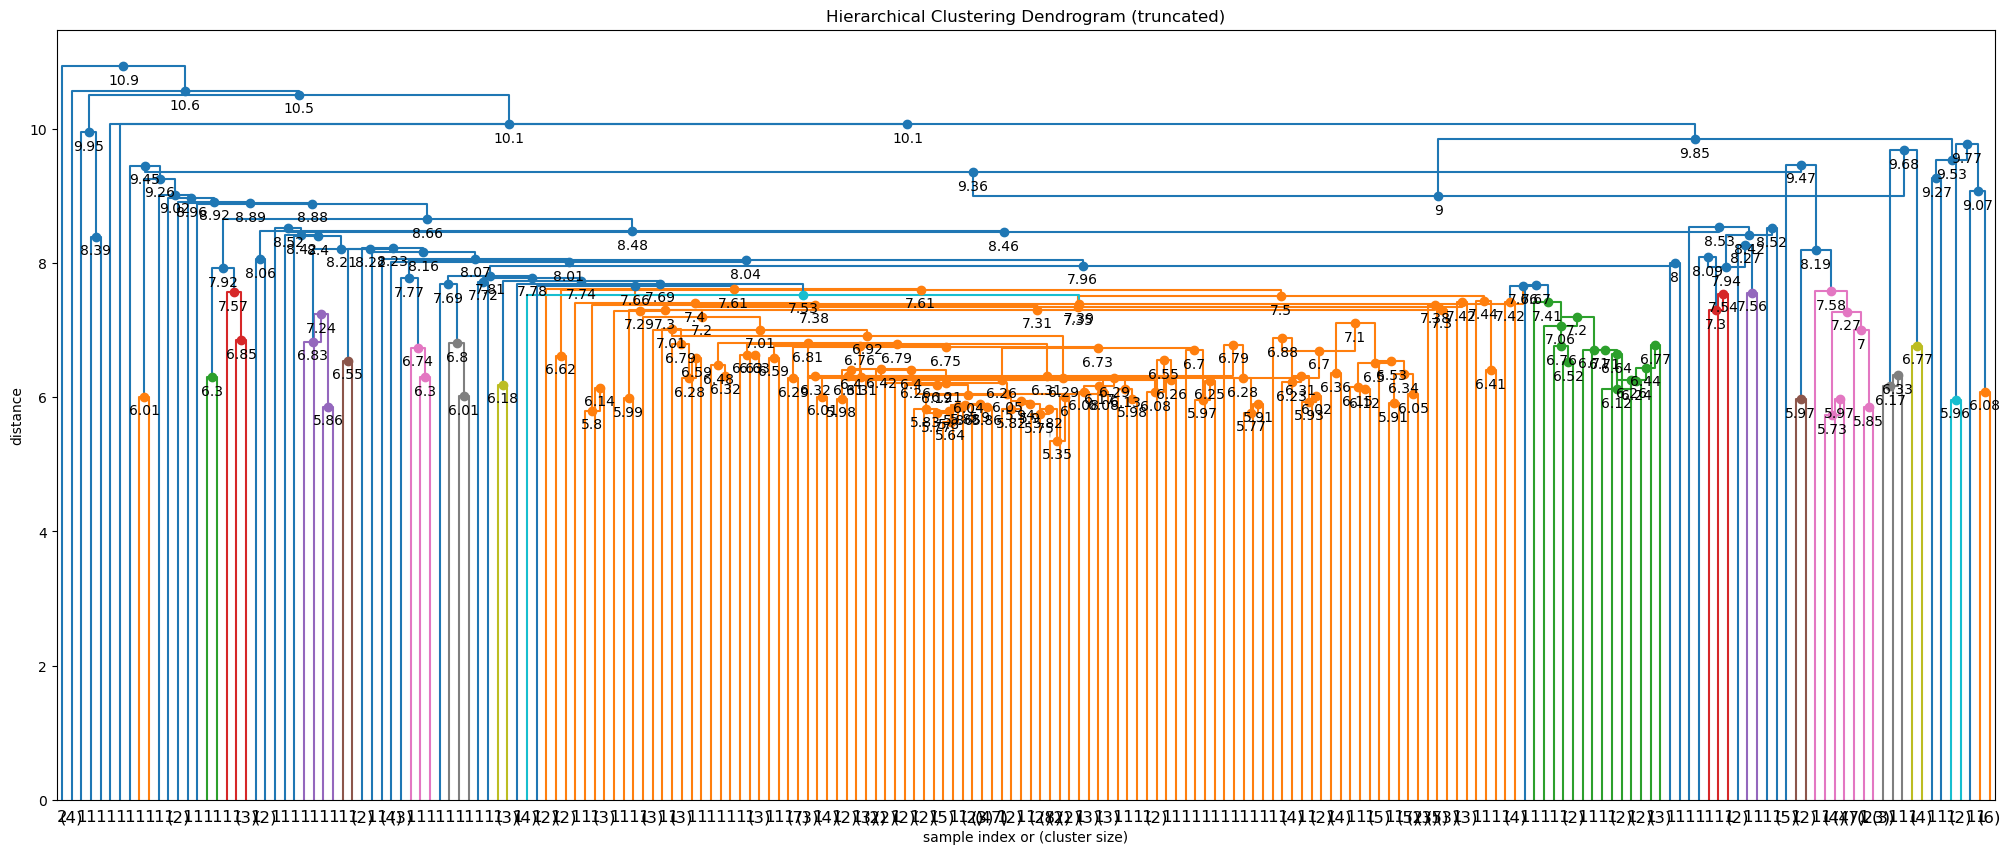

In [138]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(Z_euclidean,
                 truncate_mode='lastp',
                 p=200,
                 labels=labels_euclidean,
                 leaf_rotation=0,
                 leaf_font_size=12,
                 show_contracted=True,
                )
plt.savefig(f"dendrogram_euclidean_{n_clusters}.png")
plt.show()

In [128]:
# Calculate centroids
unique_labels = np.unique(labels_euclidean)

centroids_list = []

for i in unique_labels:
    # Take points that belong to cluster i
    cluster_points = X[labels == i]

    # Calculate the mean points of the points in the cluster
    centroid = cluster_points.mean(axis=0)

    # Add to list
    centroids_list.append(centroid)

centroids_euclidean = np.array(centroids_list)

# Reduced dataset
centroids_euclidean.shape

(2, 4096)

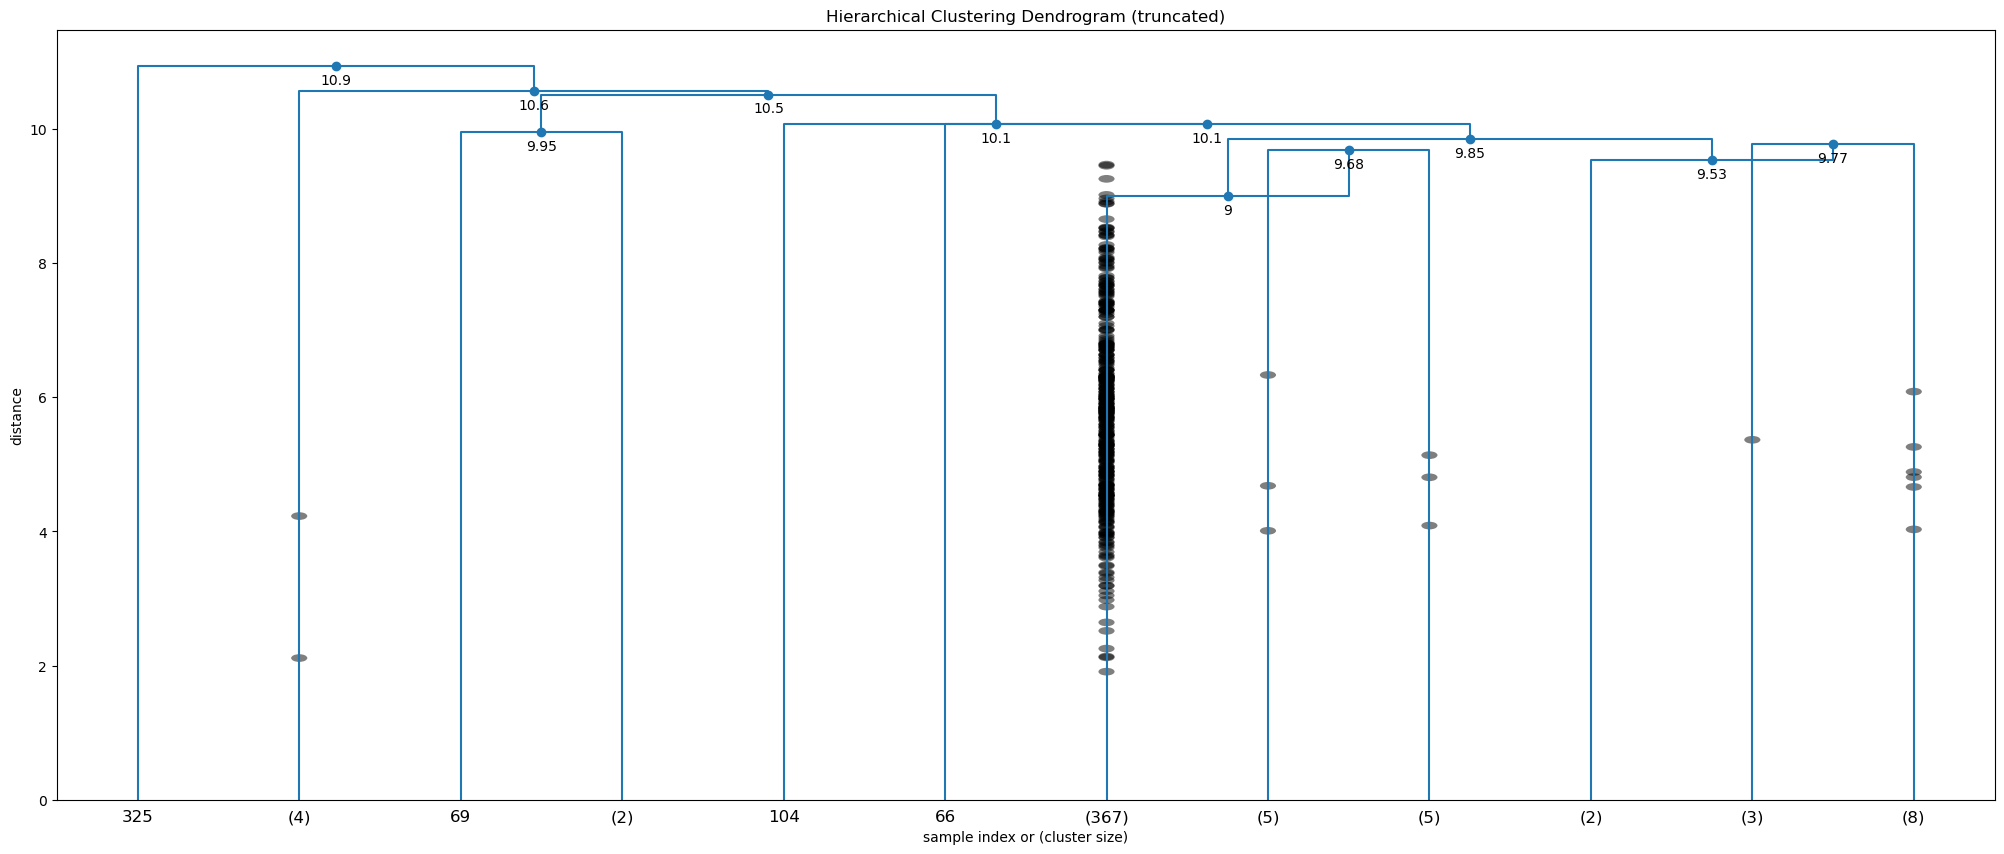

In [129]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(Z_euclidean,
                 truncate_mode='lastp',
                 p=12,
                 leaf_rotation=0,
                 leaf_font_size=12,
                 show_contracted=True,
                )
plt.savefig(f"dendrogram_euclidean_{n_clusters}.png")
plt.show()

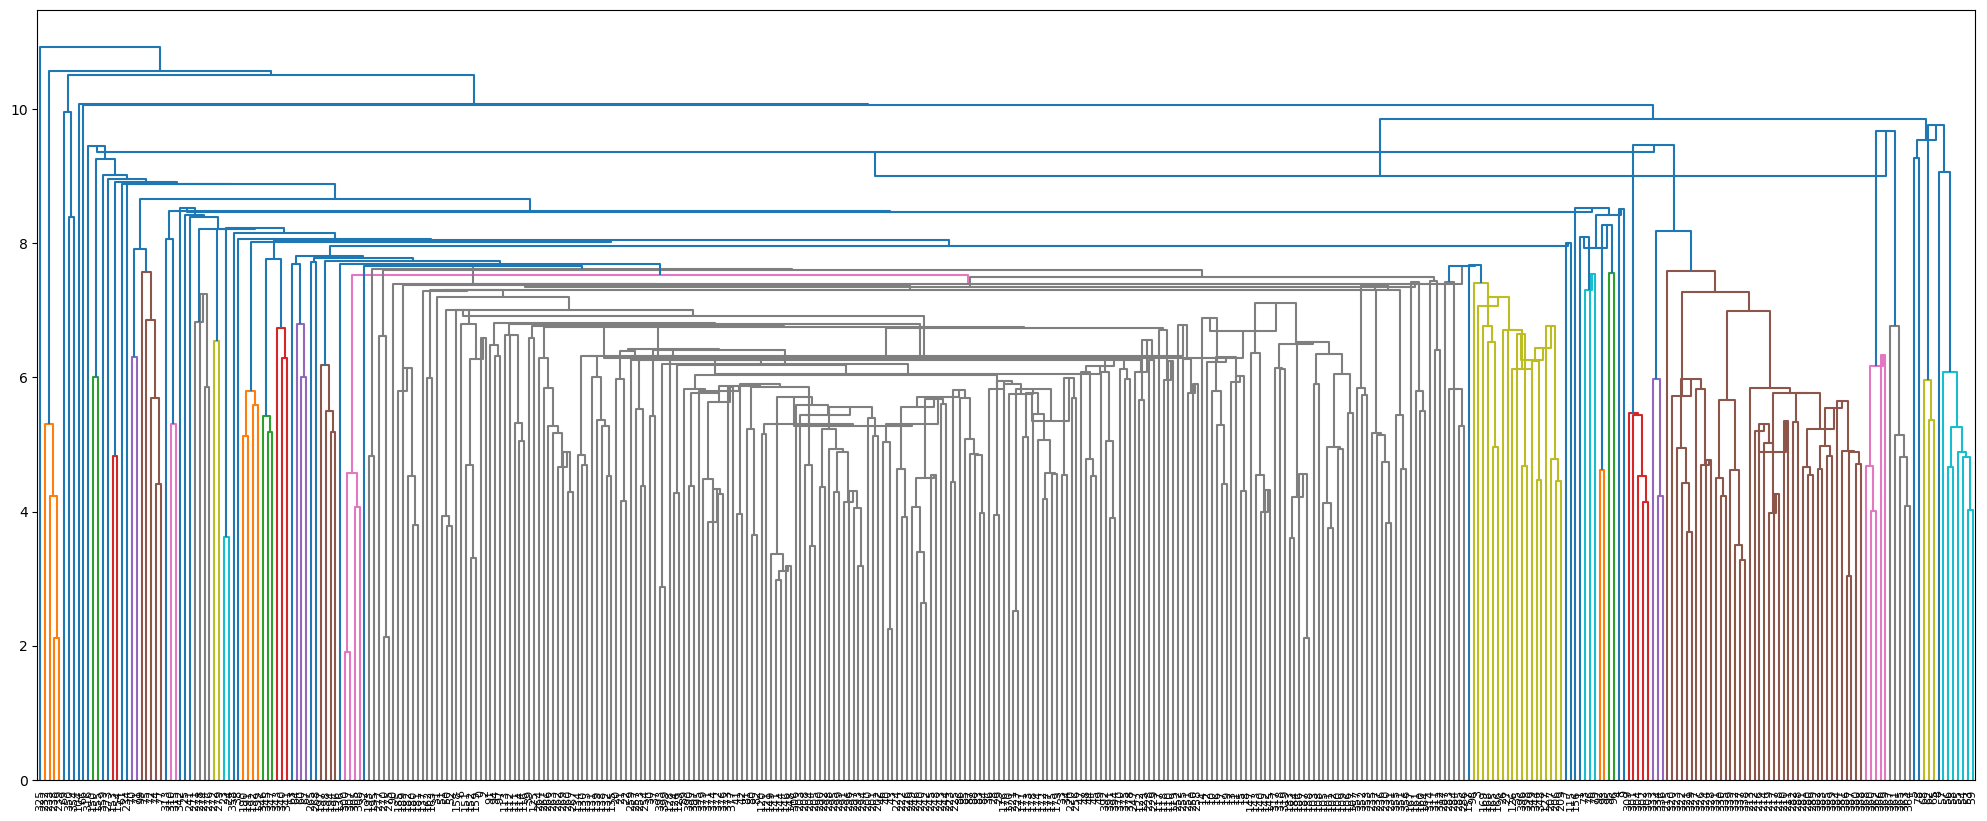

In [95]:
plt.figure(figsize=(25, 10))
dendrogram(Z_euclidean,
            leaf_rotation=90,
            leaf_font_size=8,
            show_contracted=True)
plt.savefig(f"dendrogram_euclidean_{n_clusters}.png")
plt.show()

### b) Minkowski Distance

In [67]:
# Use minkowski distance
dist_minkowski = pdist(X, metric="minkowski")

# Perform agglomerative clustering
Z_minkowski = linkage(dist_minkowski, method="centroid")

# Get labels (which cluster each point belongs to)
labels_minkowski = fcluster(Z, t=n_clusters, criterion="maxclust")

In [68]:
# Calculate centroids
unique_labels = np.unique(labels_minkowski)

centroids_list = []

for i in unique_labels:
    # Take points that belong to cluster i
    cluster_points = X[labels == i]

    # Calculate the mean points of the points in the cluster
    centroid = cluster_points.mean(axis=0)

    # Add to list
    centroids_list.append(centroid)

centroids_minkowski = np.array(centroids_list)
centroids_minkowski.shape

(40, 4096)

In [ ]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(Z_minkowski,
                 truncate_mode='lastp',
                 p=12,
                 leaf_rotation=0,
                 leaf_font_size=12,
                 show_contracted=True,
                )
plt.savefig(f"dendrogram_euclidean_{n_clusters}.png")
plt.show()

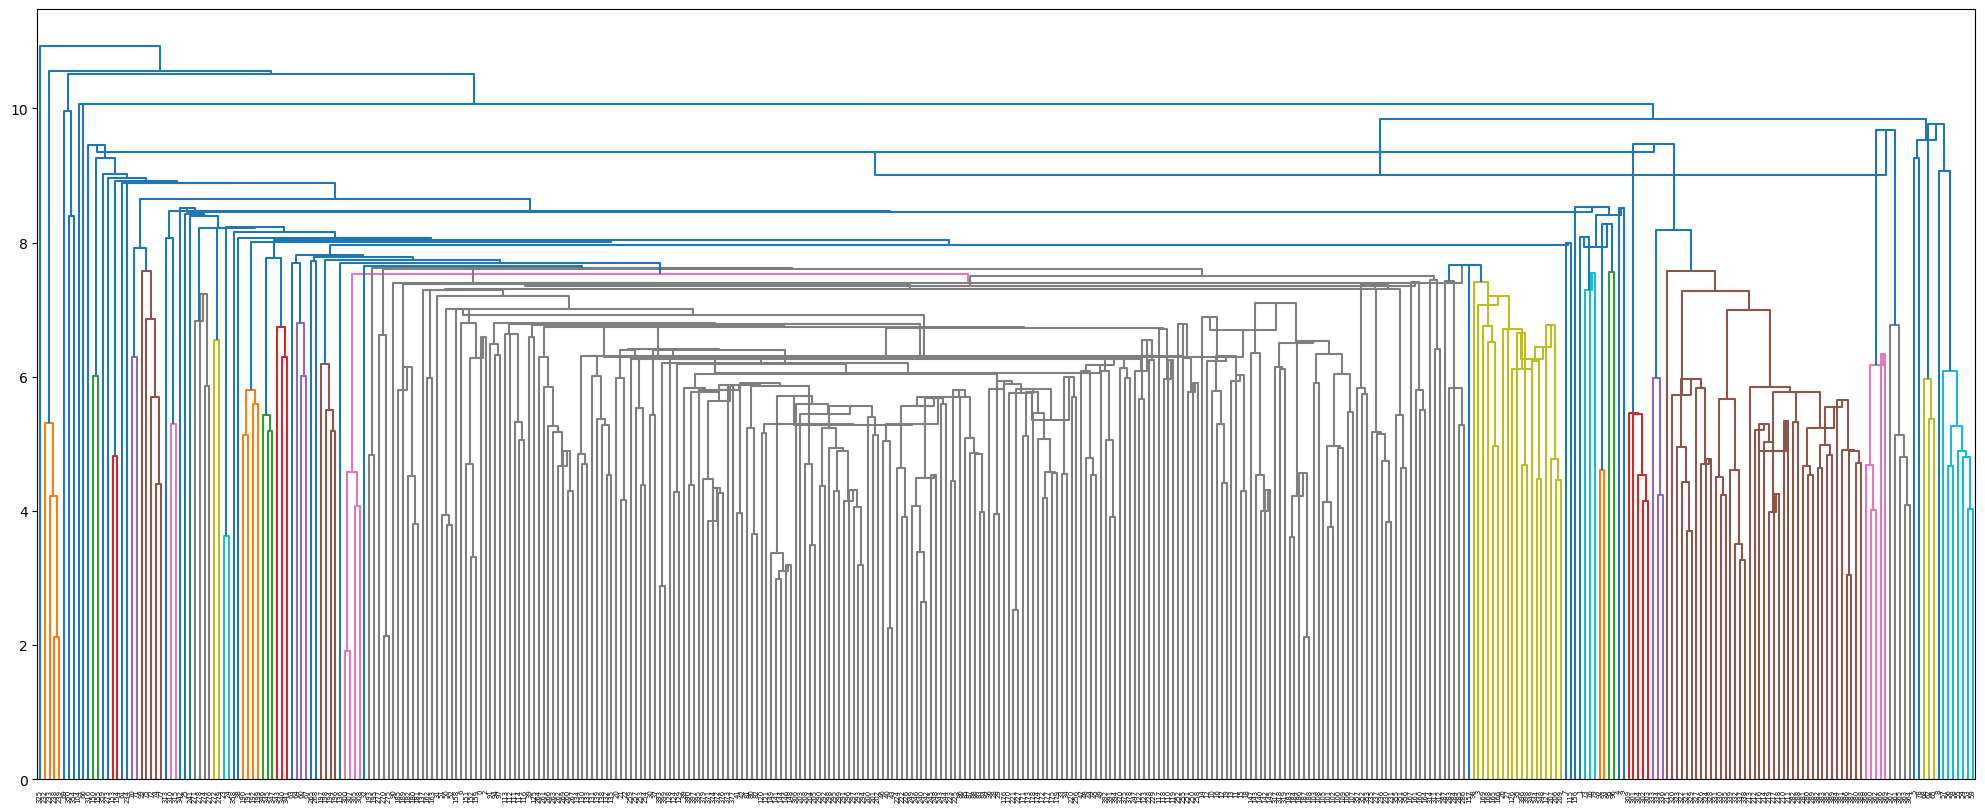

In [69]:
plt.figure(figsize=(25, 10))
dendrogram(Z_euclidean)
plt.savefig(f"dendrogram_minkowski_{n_clusters}.png")
plt.show()

### c) Cosine Similarity

---

## References  
[1] https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset  
[2] https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/